In [1]:
# add path to sispeuede to sys.path in python
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")

"""
path_git = pathlib.Path("/Users/usuario/git")
for subdir in [
    "sisepuede", 
    # "sisepuede_data_pipeline",
    # "sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))

path_pipeline = path_git.joinpath("sisepuede_data_pipeline")
"""

import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.plotting.plots as spp
import sisepuede.utilities._plotting as spu
import sisepuede.core.support_classes as sc
import sisepuede.utilities._toolbox as sf
import time
from typing import *

"""
import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib._util as lutil
"""



In [5]:
##  SETUP DIRECTORIES

path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations_peru")


##  SETUP FILES

path_data_calib = path_data.joinpath("input_all_sectors_peru.csv")
path_data_base = path_data.joinpath("real_data_TZA_PER_LKA_20250210.csv")
path_data_built = path_data.joinpath("sisepuede_raw_global_inputs_peru.csv")


##  SETUP SOME PIPELINE STUFF


file_struct = sfs.SISEPUEDEFileStructure()

# assign some shortcuts
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)


##  SOME GLOBALS

_REGION_NAME = "peru"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso", )


# Build transformations from completed raw file for 202506 model

In [35]:
df_peru = pd.read_csv(path_data_built)


In [ ]:
#df_peru.to_csv(path_data_built, encoding = "UTF-8", index = None, )

In [37]:
import sisepuede.transformers as trf

transformers = trf.Transformers(
    {},
    df_input = df_peru,
)

# initialize a transformations set
if not path_transformations.is_dir():
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )

transformations = trf.Transformations(
    path_transformations,
    transformers = transformers,
)

strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)




##  Phase 1 for transformations: run transformations one by one using defaults
- start by building all singletons to the templates to run

In [38]:

##  GET IN
strat_names = [
    x for x in strategies.attribute_table.table[strategies.field_strategy_name].to_numpy() 
    if x.startswith("Singleton")
]

# init
all_strategies_singleton = [strategies.baseline_id]

# add to list
for strat in strategies.all_strategies:
    nm = strategies.get_strategy(strat).name
    if nm in strat_names:
        all_strategies_singleton.append(strat)




# build templates--trajectory groups are not important right now
examples = sxl.SISEPUEDEExamples()
df_vargroups = examples("variable_trajectory_group_specification")
strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups, 
    include_simplex_group_as_trajgroup = True,
    strategies = all_strategies_singleton,
)


0

# Next, build a SISEPUEDE object and load strategies

In [ ]:
import sisepuede as si

ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    initialize_as_dummy = False,
    regions = [_REGION_NAME],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)





## then, run the strategies one by one

In [ ]:

dict_run = {
    ssp.key_future: [0],
    ssp.key_design: [0],
    ssp.key_strategy: all_strategies_singleton,
}

# we'll save inputs since we're doing a small set of runs
dict_successful = ssp(
    dict_run,
    force_overwrite_existing_primary_keys = True,
    save_inputs = True,
)

##  Read the outputs and inputs back in

In [ ]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

# Bulid Dataset for 202506 model with data we have

- Pull data fromo original repo (df_peru_base)
- Update with latest data (from new repo)
- Fill in values for new vars using `temp_update_fields_from_wv_to_main`
- Check if anything is missing

In [ ]:
importlib.reload(dc)
construct = dc.SISEPUEDEDataConstructs(
    path_output_database = "/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite",
)

path_repo = pathlib.Path("/Users/usuario/SISEPUEDE_DATA_REPOSITORY")
repo = pu.Repository(
    {
        "local": {
            "path": str(path_repo)
        }
    }
)

In [66]:
import temp_update_fields_from_wv_to_main as temp 

examples = sxl.SISEPUEDEExamples()
df_example_input = examples("input_data_frame")

# get from original repo
df_peru_base = (
    pd.read_csv(path_data_base)
    .rename(
        columns = {
            "iso_code3": regions.field_iso,
            "Year": time_periods.field_year,
        }
    )
)

# get from pipeline
df_from_pipeline = construct.build_inputs_from_database(
    regions_keep = [_REGION_NAME],
)


# add in pipeline-based data
df_peru = sf.match_df_to_target_df(
    df_peru_base[
        df_peru_base[regions.field_iso].isin([_REGION_ISO])
    ],
    
    df_from_pipeline
    .drop(columns = [regions.field_iso]),
    
    [
        construct.time_periods.field_year,
    ],
    overwrite_only = False,
)

##  PULL FROM EXAMPLE DF

# fields not in peru
fields_missing = [
    x for x in df_example_input.columns 
    if (x not in df_peru.columns) 
    and (x in matt.all_variable_fields_input)
]

# specify fields to pull from the example
fields_from_ex = [
    x for x in fields_missing 
    if not (
        x.startswith("factor_lndu")
        or x.startswith("frac_lndu_")
    )
]

fields_from_ex = [
    x for x in fields_from_ex
    if (x not in df_peru.columns)
]

# merge in from ex
df_peru = pd.merge(
    df_peru,
    df_example_input[fields_from_ex + [time_periods.field_time_period]],
)


##  TEMPORARY SCRIPT FOR MOVING FROM working_version TO latest full version

df_peru = temp.update_fields(
    df_peru,
    matt,
)

# add in key
df_peru[regions.key] = _REGION_NAME


# Try running to make sure it works and looks reasonable

In [39]:
models = sm.SISEPUEDEModels(
    matt,
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)
df_run_enerprod = models(df_peru, include_electricity_in_energy = True, )

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1303.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


2025-30-Jun 12:20:12.448 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmptn7klt9h.sqlite.
2025-30-Jun 12:20:12.610 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmptn7klt9h.sqlite.
2025-30-Jun 12:20:20.073 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-30-Jun 12:21:02.761 Finished modeling scenario.


In [85]:
df_run = models(df_peru, include_electricity_in_energy = True, )

2025-06-Jun 12:26:46.217 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmpcloqz76s.sqlite.
2025-06-Jun 12:26:46.321 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/article_6_tanzania_sri_lanka_peru/tmpcloqz76s.sqlite.
2025-06-Jun 12:26:56.975 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-06-Jun 12:27:28.961 Finished modeling scenario.


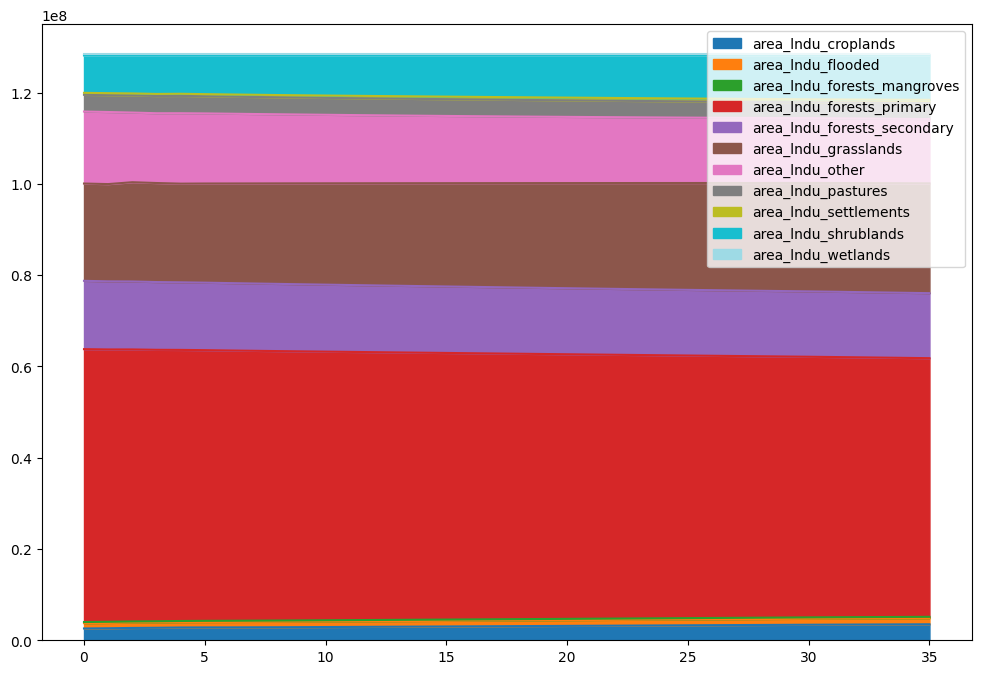

In [40]:
modvar = matt.get_variable("Land Use Area", )
fig, ax = plt.subplots(figsize = (12, 8))
df_run_enerprod[modvar.fields].plot.area(cmap = "tab20", ax = ax, )
ax.legend(loc = "upper right")


In [212]:
vals = matt.get_attribute_table("Liquid Waste").key_values
for k in vals:
    print(k)

ww_domestic_rural
ww_domestic_urban
ww_industrial


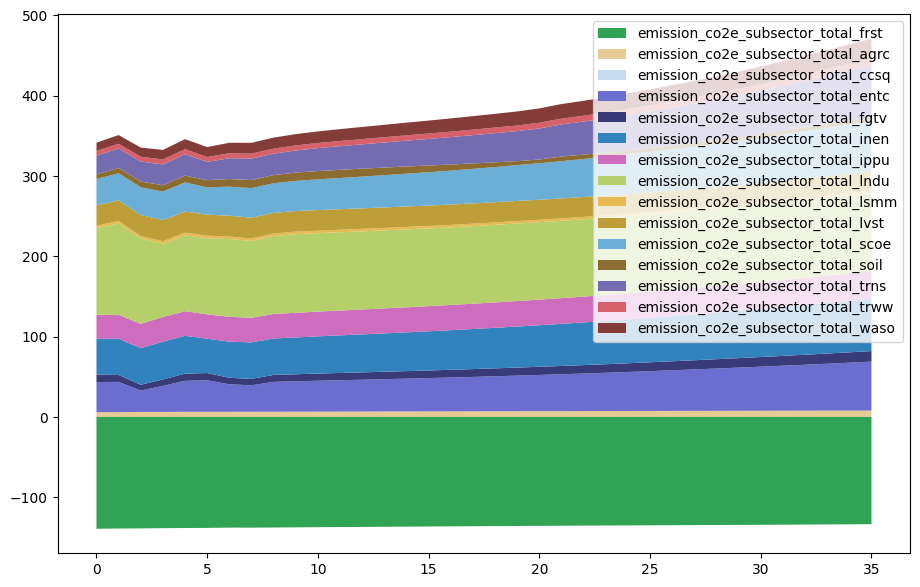

In [42]:
fig, ax = plt.subplots(figsize = (11, 7))
spp.plot_emissions_stack(
    df_run_enerprod,
    matt,
    figtuple = (fig, ax),
)

ax.legend()


# Skip here to run model

In [104]:
df_peru.to_csv(
    dir_data.joinpath("sisepuede_raw_global_inputs_peru.csv"),
    encoding = "UTF-8",
    index = None,
)

In [168]:
skip = 0


In [202]:
import sisepuede.transformers.transformers as trf2
importlib.reload(trf2)

transformers = trf2.Transformers(
    {},
    df_input = df_peru,
)

